In [2]:
from collections import defaultdict, Counter
import os, itertools, copy, datetime, importlib, logging, pickle, json
from tqdm.auto import tqdm
from pathlib import Path
from util import config_logger

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors, KernelDensity
from scipy.stats import rankdata, spearmanr, pearsonr
from statsmodels.stats.multitest import multipletests
from umap import UMAP
from anndata import AnnData
import scanpy as sc
from fa2 import ForceAtlas2
import networkx as nx

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

logger = config_logger(logging.getLogger(__name__))

In [3]:
genes_g1s = np.loadtxt('/home/tianming/work/Researches/scRNAseq_data/Tirosh2016/genes_G1S.txt', dtype=object)
genes_g2m = np.loadtxt('/home/tianming/work/Researches/scRNAseq_data/Tirosh2016/genes_G2M.txt', dtype=object)
print(len(genes_g1s), len(genes_g2m))

43 55


In [4]:
with open('color_map_CD.json', 'r') as f:
    color_map = json.load(f)

# GAGE-seq

In [10]:
from backend import load_gene_annotation, get_gene_scores
df_gene_anno = load_gene_annotation(version='hg38').set_index('gene_name')

path2root = Path(f'/work/magroup/tianming/Researches/sc-hic/data2/final')

df_doublet = []
for lib_name in ['CD-0722-1', 'CD-0722-2', 'CD-0722-4']:
    with open(path2root / 'results' / f'doublet_{lib_name}_complete_hg38_filtered.pkl', 'rb') as f:
        df = pickle.load(f)
    df.index = pd.Series([f'{lib_name}_{w}' for w in df.index], name=df.index.name)
    df_doublet.append(df)
df_doublet = pd.concat(df_doublet, axis=0)

adata = sc.read_10x_mtx(path2root / 'results' / 'RNA_CD_complete_hg38_filtered_10x')
cell_id_all = np.loadtxt(path2root / 'results' / 'RNA_CD_complete_hg38_filtered_10x' / 'barcodes.tsv', dtype=object)
adata.obs.index = cell_id_all
with open(path2root / 'results' / f'meta_CD_complete_hg38_filtered.pkl', 'rb') as f:
    df_meta = pickle.load(f)
adata.obs = pd.concat([adata.obs, df_meta], axis=1)
del df_meta
print(adata.shape)

adata = adata[df_doublet[(1e-2, .3)] == 0, :]
print(adata.shape)
adata = adata.copy()
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_gage_raw = adata.copy()
adata.raw = adata

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
adata_gage = adata
adata
del adata

(3426, 27126)
(2815, 27126)


In [15]:
adata_gage.obs['phase'] = pd.read_csv(
    '/work/magroup/tianming/Researches/sc-hic/data2/final/results/phase-scanpy_CD.csv', sep='\t',
    index_col=0, header=0)

In [17]:
adata_gage_g1 = adata_gage[adata_gage.obs.phase.eq('G1')].copy()

2720


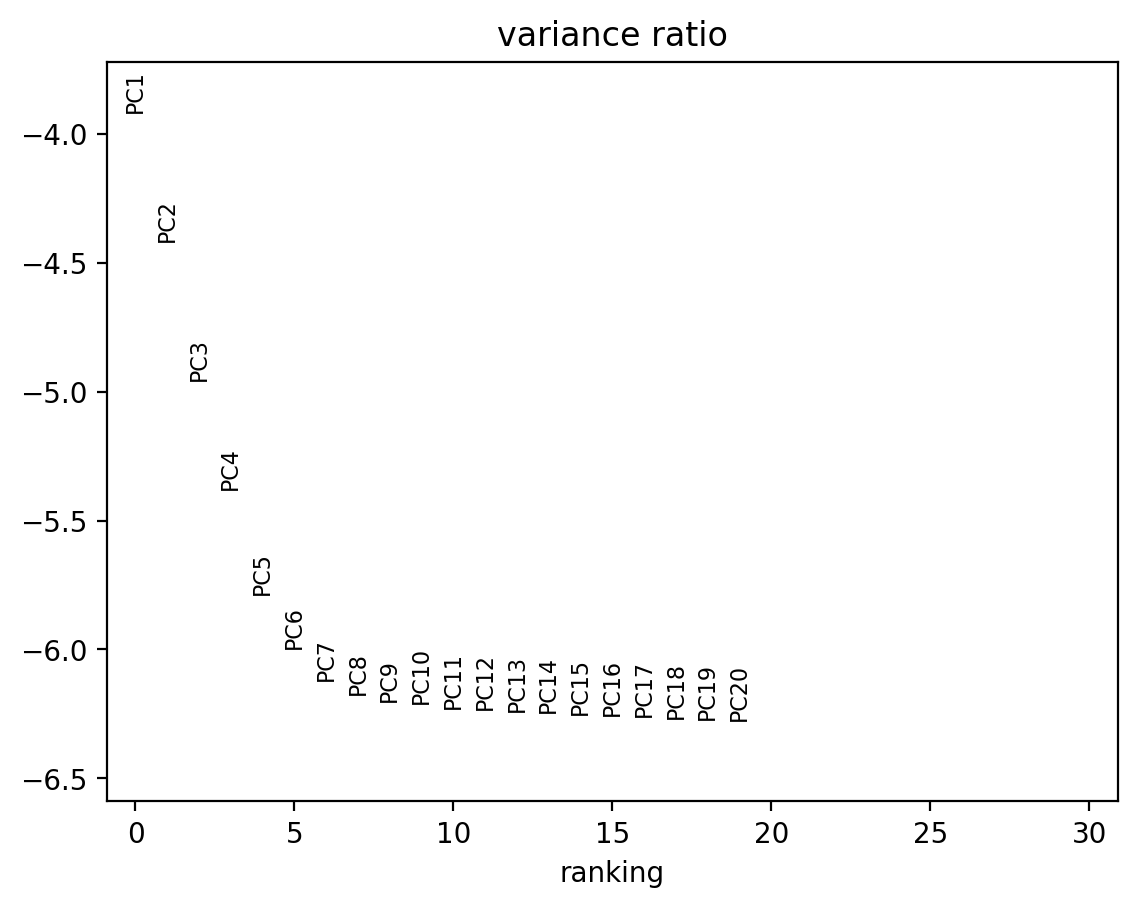

/work/magroup/tianming/Researches/sc-hic/data2/final/results/PCA_RNA_CD_complete_hg38_filtered.csv


In [18]:
adata = adata_gage_g1
x = adata_gage_raw[adata_gage_g1.obs.index][:, adata_gage_g1.var.index].copy().X
adata_gage_g1.var['highly_variable'] = np.asarray((x > 0).mean(0)).squeeze(0) > .1
print(adata_gage_g1.var['highly_variable'].sum())
sc.tl.pca(adata, n_comps=20, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

path2file = path2root / 'results' / 'PCA_RNA_CD_complete_hg38_filtered.csv'
print(path2file)
pd.DataFrame(
    data=adata.obsm['X_pca'],
    index=adata.obs.index,
    columns=[f'PC_{i+1}' for i in range(adata.obsm['X_pca'].shape[1])],
).to_csv(path2file)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=7)
sc.tl.louvain(adata, resolution=1)
sc.tl.umap(adata, min_dist=.1)
sc.pl.umap(adata, color='louvain')
path2file = path2root / 'results' / 'UMAP_RNA_CD_complete_hg38_filtered.csv'
print(path2file)
pd.DataFrame(
    data=adata.obsm['X_umap'],
    index=adata.obs.index,
    columns=[f'UMAP_{i+1}' for i in range(adata.obsm['X_umap'].shape[1])],
).to_csv(path2file)
adata_gage_g1 = adata

In [ ]:
adata = adata_gage_g1
mapping = {
    4: 'HSC',
    3: 'MPP',
    6: 'LMPP',
    7: 'MEP',
    9: 'MLP',
    0: 'B-NK',
}
adata.obs['cell type'] = adata.obs['louvain'].apply(lambda x: mapping.get(int(x), x))
categories = np.array(list(mapping.values()))
print(categories)
categories = list(categories[np.sort(np.unique(categories, return_index=True)[1])])
categories += list(set(adata_gage_g1.obs['cell type']) - set(categories))
adata.obs['cell type'] = pd.Categorical(adata.obs['cell type'], categories=categories)
path2file = path2root / 'results' / 'meta-python_CD_complete_hg38_filtered.csv'
print(path2file)
adata.obs[['louvain', 'cell type']].to_csv(path2file)

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x=pd.Series(adata.obsm['X_umap'][:, 0], index=adata.obs.index, name='UMAP 1'),
    y=pd.Series(adata.obsm['X_umap'][:, 1], index=adata.obs.index, name='UMAP 2'),
    hue=adata.obs['cell type'], ax=ax, s=30, edgecolor='none', palette=color_map)
for celltype, xy in pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index)\
    .groupby(adata.obs['cell type']).mean().iterrows():
    ax.text(*list(xy), celltype)
plt.show()
plt.close('all')

# plt.figure()
sc.pl.violin(
    adata_gage_g1, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True, groupby='cell type', palette=color_map)
plt.show()
plt.close('all')

(837, 27126)
3290


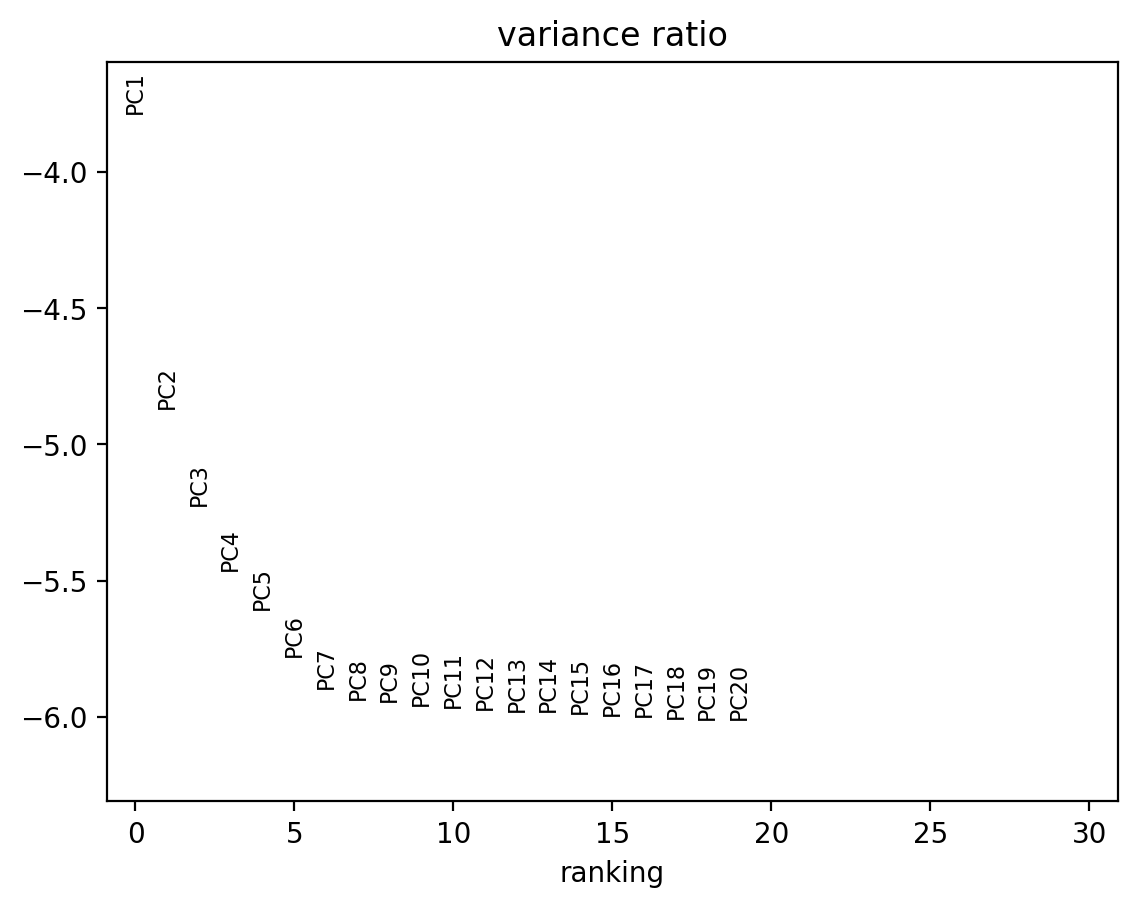

/work/magroup/tianming/Researches/sc-hic/data2/final/results/UMAP_RNA_CD_complete_hg38_filtered_highquality.csv


In [23]:
adata = adata_gage_g1[adata_gage_g1.obs['cell type'].isin([
    'HSC', 'MPP', 'LMPP', 'MEP', 'MLP', 'B-NK',
])].copy()
print(adata.shape)
x = adata_gage_raw[adata.obs.index][:, adata.var.index].copy().X
adata.var['highly_variable'] = np.asarray((x > 0).mean(0)).squeeze(0) > .1
print(adata.var['highly_variable'].sum())

sc.tl.pca(adata, n_comps=20, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=6)
sc.tl.umap(adata, min_dist=.1)

path2file = path2root / 'results' / 'UMAP_RNA_CD_complete_hg38_filtered_highquality.csv'
print(path2file)
pd.DataFrame(
    data=adata.obsm['X_umap'],
    index=adata.obs.index,
    columns=[f'UMAP_{i+1}' for i in range(adata.obsm['X_umap'].shape[1])],
).to_csv(path2file)

adata_gage_g1_filtered = adata

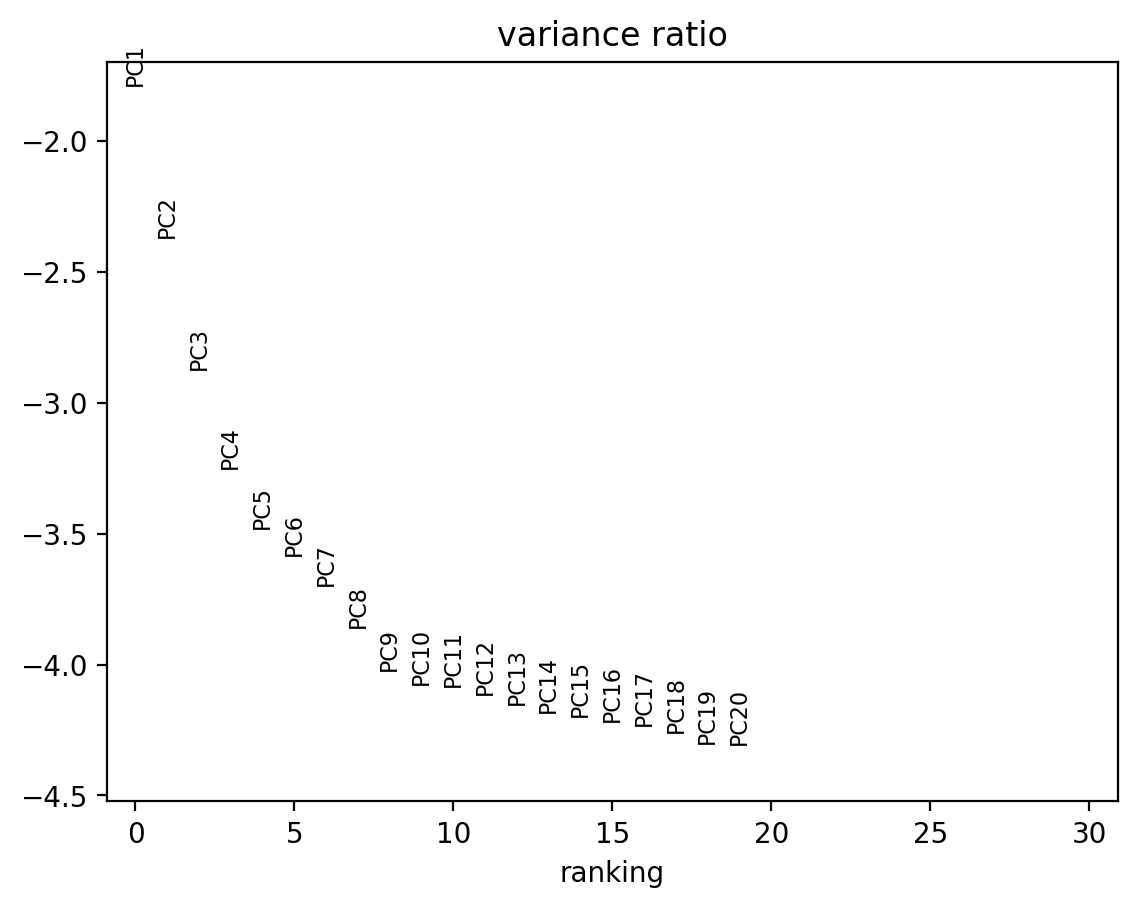

In [54]:
s = pd.read_csv(
    '/work/magroup/tianming/Researches/sc-hic/data2/final/results/PCA_DNA-FH-G1_CD_complete_hg38_filtered_500kb.csv',
    header=0, index_col=0,
)
s = s.loc[adata_gage_g1_filtered.obs.index]
adata = AnnData(s)
adata.obs['cell type'] = adata_gage_g1_filtered.obs['cell type']

sc.pp.pca(adata)
sc.tl.pca(adata, n_comps=20, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=8)
sc.tl.umap(adata, min_dist=.05)

adata_fh = adata

/work/magroup/tianming/Researches/sc-hic/data2/final/figures-CD-paper/embedding-umap-highquality.png
/work/magroup/tianming/Researches/sc-hic/data2/final/figures-CD-paper/embedding-umap-highquality.pdf


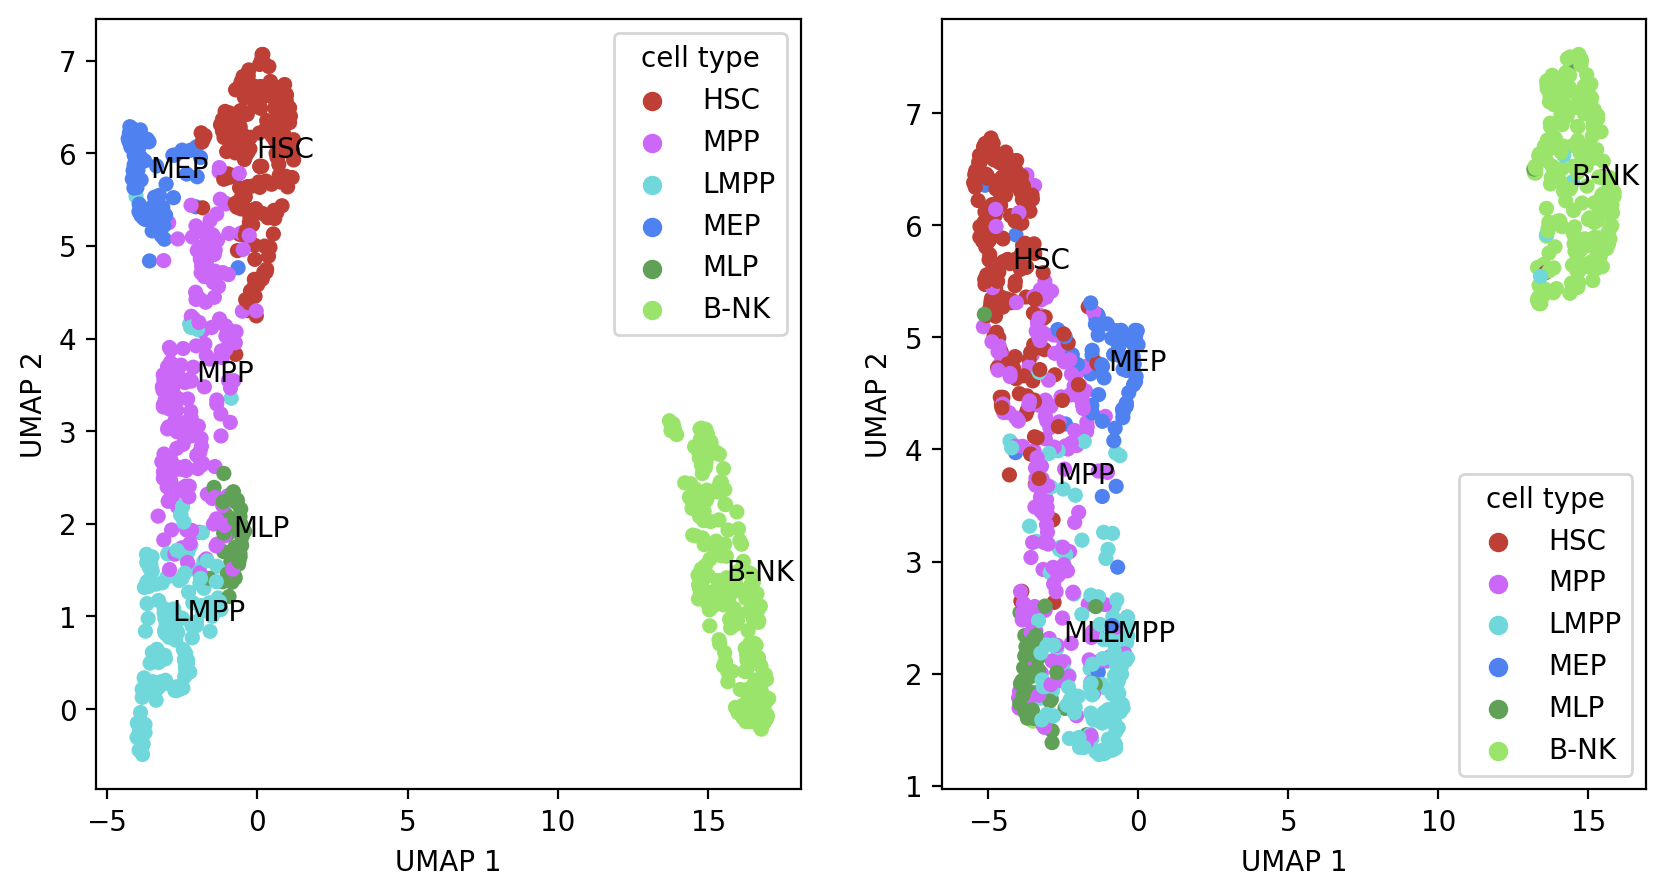

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for ax, adata in zip(axes, [adata_gage_g1_filtered, adata_fh]):
    sns.scatterplot(
        x=pd.Series(adata.obsm['X_umap'][:, 0], index=adata.obs.index, name='UMAP 1'),
        y=pd.Series(adata.obsm['X_umap'][:, 1], index=adata.obs.index, name='UMAP 2'),
        hue=adata.obs['cell type'], ax=ax, s=30, edgecolor='none', palette=color_map)
    for celltype, xy in pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index)\
        .groupby(adata.obs['cell type']).mean().iterrows():
        ax.text(*list(xy), celltype)
for suffix in ['png', 'pdf']:
    path2file = path2root / 'figures-CD-paper' / f'embedding-umap-highquality.{suffix}'
    print(path2file)
    plt.savefig(path2file, dpi=600)
plt.show()
plt.close('all')